In [121]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pydicom, cv2, torch
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import multiprocessing as mp

mp.set_start_method('fork', force=True)

Cohort Exploration

In [109]:
patient_df = pd.read_csv('/Users/jiwoo_noh/Downloads/admissions.csv')
dicom_df   = pd.read_csv('/Users/jiwoo_noh/Downloads/cxr-record-list.csv')

dicom_filtered = dicom_df[
    dicom_df['subject_id'].astype(str).str.startswith(('10', '11', '12', '13'))
]

merged = dicom_filtered.merge(
    patient_df[['subject_id', 'ethnicity']],
    on='subject_id',
    how='inner'
)

to_drop = ['OTHER', 'UNKNOWN', 'UNABLE TO OBTAIN']

merged = merged[~merged['ethnicity'].isin(to_drop)]

result = merged[['subject_id', 'ethnicity', 'path']]

print(result.head())

result.to_csv(
    '/Users/jiwoo_noh/Downloads/patient_ethnicity_with_path.csv',
    index=False
)


   subject_id ethnicity                                               path
0    10000032     WHITE  files/p10/p10000032/s50414267/02aa804e-bde0afd...
1    10000032     WHITE  files/p10/p10000032/s50414267/02aa804e-bde0afd...
2    10000032     WHITE  files/p10/p10000032/s50414267/02aa804e-bde0afd...
3    10000032     WHITE  files/p10/p10000032/s50414267/02aa804e-bde0afd...
4    10000032     WHITE  files/p10/p10000032/s50414267/174413ec-4ec4c1f...


In [110]:
labels_df = pd.read_csv('/Users/jiwoo_noh/Downloads/patient_ethnicity_with_path.csv')

eth_df = labels_df[['subject_id','ethnicity']].drop_duplicates()
counts = eth_df['subject_id'].value_counts()
ambiguous_ids = counts[counts > 1].index.tolist()

if ambiguous_ids:
    print(f"Removing {len(ambiguous_ids)} patients with inconsistent ethnicity:", ambiguous_ids)

labels_df = labels_df[~labels_df['subject_id'].isin(ambiguous_ids)].reset_index(drop=True)
labels = labels_df['ethnicity']
subject_id = labels_df['subject_id']

Removing 169 patients with inconsistent ethnicity: [10253747, 13647995, 13413901, 13166511, 13961572, 10792610, 11668016, 11319919, 10827166, 13382305, 13843470, 11742857, 10367781, 12604466, 13516267, 13705993, 13228076, 12546830, 10190829, 12547294, 13224214, 11121223, 12250460, 13681703, 10413587, 13383377, 13429359, 12081472, 11906175, 13222436, 13675141, 11900468, 13752571, 10692049, 11845541, 12136944, 12807740, 13150918, 11051429, 10604743, 12493668, 12297145, 13025966, 10942097, 11937117, 12580408, 13323674, 13465969, 12891356, 11401186, 13881858, 10916975, 12077819, 10101795, 12001183, 10719490, 11411992, 13775723, 11307110, 10720865, 11617122, 13287790, 10056612, 10731206, 11968017, 13440918, 12673327, 10049782, 12355847, 12565496, 11312381, 12789108, 10575262, 13783920, 11925631, 13582085, 13824839, 10242587, 11619714, 11608914, 11138817, 12704996, 13965801, 11552479, 11408332, 10798787, 13964931, 12847427, 12326925, 13281197, 12903377, 11480454, 12916923, 11242742, 12125322

In [111]:
# calculate data demographics
race_counts = labels_df['ethnicity'].value_counts()
print(race_counts)

unique_subject = labels_df['subject_id'].unique()

print(len(unique_subject))

ethnicity
WHITE                            630245
BLACK/AFRICAN AMERICAN           230747
HISPANIC/LATINO                   86697
ASIAN                             17664
AMERICAN INDIAN/ALASKA NATIVE      1824
Name: count, dtype: int64
19779


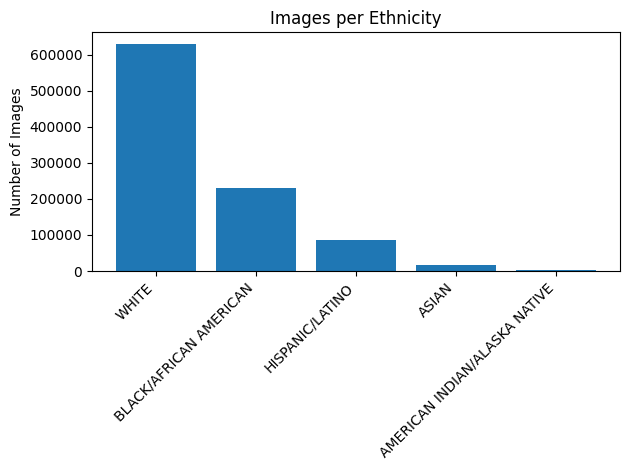

In [112]:
# plotting race distribution
plt.figure()
plt.bar(race_counts.index, race_counts.values)
plt.ylabel('Number of Images')
plt.title('Images per Ethnicity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

DICOM Preprocessing

In [113]:
# preprocessing and generating model inputs
# need the local file structure that each patient id head is within
local_path_stem = '/Users/jiwoo_noh/Downloads/physionet.org/files/mimic-cxr/2.1.0/'

valid_rows = []
images_dict = {}
labels_dict = {}

for _, row in labels_df.iterrows():
    patient_id = row['subject_id']
    full_path  = os.path.join(local_path_stem, row['path'])
    if not os.path.exists(full_path):
        continue

    try:
        #img_tensor = preprocess_dicom_to_tensor(full_path, transform)
        #images_dict[(patient_id, full_path)] = img_tensor
        labels_dict[(patient_id, full_path)] = row['ethnicity']

        # record this row with full_path for your valid_df
        new_row = row.copy()
        new_row['path'] = full_path
        valid_rows.append(new_row)

    except Exception as e:
        print(f"error loading {full_path}: {e}")

# save the new list of patients (this is the data we will actually have access to)
valid_df = pd.DataFrame(valid_rows)
valid_df.to_csv('downloaded_data_info.csv', index=False)

ethnicity
BLACK/AFRICAN AMERICAN    1896
WHITE                     1288
ASIAN                       35
Name: count, dtype: int64
Number of unique patients:52


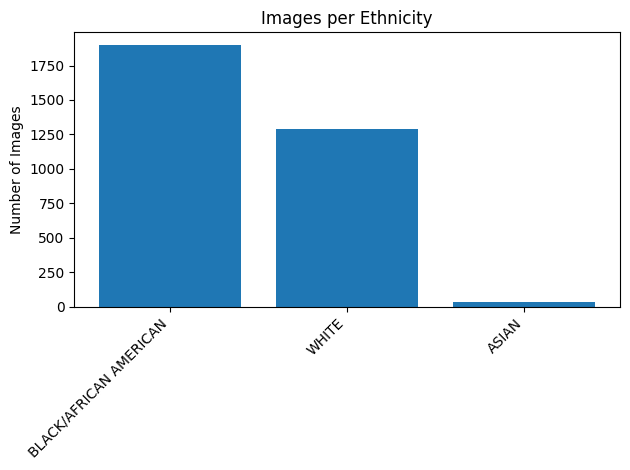

In [114]:
## plot the final patient demographics after filtering and downloading
race_counts = valid_df['ethnicity'].value_counts()
print(race_counts)

unique_subject = valid_df['subject_id'].unique()

print(f'Number of unique patients:{len(unique_subject)}')

plt.figure()
plt.bar(race_counts.index, race_counts.values)
plt.ylabel('Number of Images')
plt.title('Images per Ethnicity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [116]:
# by patient train/validation/test split
# stratified by ethnicity
patient_labels = valid_df.groupby('subject_id')['ethnicity'].first()
unique_patients = patient_labels.index.tolist()
patient_label_list = patient_labels.tolist()

# 80 train, val 10, test 10
train_patients, temp_patients = train_test_split(unique_patients, test_size = 0.2, stratify=patient_label_list, random_state = 42)
temp_labels = patient_labels.loc[temp_patients].tolist()
val_patients, test_patients = train_test_split(temp_patients, test_size = 0.5, stratify=temp_labels, random_state = 42)

print(f"Train size: {len(train_patients)}")
print(f"Val   size: {len(val_patients)}")
print(f"Test  size: {len(test_patients)}")

# complete training, validation, testing datasets because patients have more than one dicom
train_items = []
val_items = []
test_items = []

for (patient_id, path) in labels_dict.keys():
    if patient_id in train_patients:
        train_items.append((patient_id, path))
    elif patient_id in val_patients:
        val_items.append((patient_id, path))
    elif patient_id in test_patients:
        test_items.append((patient_id, path))
    else:
        print("Patient ID: {patient_id} not found in any split but is in the processed images. Something is seriously wrong. Taco.")

# output lists of patient, path pairs as keys
# need to have labels_dict dictionary loaded in --> tensors as items in this dictionary

Train size: 41
Val   size: 5
Test  size: 6


In [139]:
import os
import pydicom
import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# drop bad DICOMS
def filter_valid_items(items):
    valid = []
    for pid, path in items:
        try:
            ds = pydicom.dcmread(path)
            _  = ds.pixel_array      # trigger decode
            valid.append((pid, path))
        except Exception as e:
            print(f"Skipping corrupted/unsupported DICOM {path}: {e}")
    return valid

# Apply filter before building ANY Dataset
train_items = filter_valid_items(train_items)
val_items   = filter_valid_items(val_items)
test_items  = filter_valid_items(test_items)

unique_labels = sorted(set(labels_dict.values()))
label2idx     = {lab: i for i, lab in enumerate(unique_labels)}

# 1) Dataset class 
class DicomDataset(Dataset):
    def __init__(self, items, labels_dict, label2idx, transform=None):
        self.items     = items
        self.labels    = labels_dict
        self.label2idx = label2idx
        self.transform = transform

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        pid, path = self.items[idx]
        ds  = pydicom.dcmread(path)
        arr = ds.pixel_array.astype(np.float32)
        arr = (arr - arr.min()) / (arr.ptp() + 1e-6)
        img = Image.fromarray((arr * 255).astype(np.uint8))
        if self.transform:
            img = self.transform(img)

        raw_label = self.labels[(pid, path)]
        label     = self.label2idx[raw_label]
        return img, label


# 2) Compute train‐set mean & std 
def compute_mean_std(loader):
    mean = 0.0
    var  = 0.0
    n    = 0
    for imgs, _ in loader:
        # imgs: [B, 1, H, W]
        b = imgs.size(0)
        imgs = imgs.view(b, imgs.size(1), -1)   # [B, C, H*W]
        mean += imgs.mean(2).sum(0)
        var  += imgs.var(2, unbiased=False).sum(0)
        n    += b
    mean /= n
    var  /= n
    std   = torch.sqrt(var)
    return mean, std


stats_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),   # yields [1,H,W] in [0,1]
])

# num_workers=0 to avoid multiprocessing errors in notebooks
stats_loader = DataLoader(
    DicomDataset(train_items, labels_dict, label2idx, transform=stats_transform),
    batch_size=32, shuffle=False, num_workers=0
)

train_mean, train_std = compute_mean_std(stats_loader)
print(f"Train mean: {train_mean.item():.4f},  std: {train_std.item():.4f}")


# 3) final transforms
train_transform = transforms.Compose([ # data augmentation to prevent overfitting
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(0.1,0.1),
    transforms.ToTensor(),
    transforms.Normalize([train_mean.item()], [train_std.item()]),
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([train_mean.item()], [train_std.item()]),
])

batch_size = 32
loader_kwargs = dict(num_workers=0, pin_memory=True, batch_size=batch_size)

# final loaders
train_loader = DataLoader(
    DicomDataset(train_items, labels_dict, label2idx, transform=train_transform),
    batch_size=batch_size, shuffle=True,  num_workers=0, pin_memory=True
)
val_loader   = DataLoader(
    DicomDataset(val_items,   labels_dict, label2idx, transform=val_transform),
    batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True
)
test_loader  = DataLoader(
    DicomDataset(test_items,  labels_dict, label2idx, transform=val_transform),
    batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True
)



Train mean: 0.4872,  std: 0.2570


In [140]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import densenet121
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import pydicom
import numpy as np
from PIL import Image
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

unique_labels = sorted(set(labels_dict.values()))
label2idx     = {lab: idx for idx, lab in enumerate(unique_labels)}
num_classes   = len(unique_labels)
print(f"Classes ({num_classes}): {unique_labels}")

model = densenet121(pretrained=True)

# swap first conv to accept 1 channel instead of 3
model.features.conv0 = nn.Conv2d(
    in_channels=1,
    out_channels=model.features.conv0.out_channels,
    kernel_size=model.features.conv0.kernel_size,
    stride=model.features.conv0.stride,
    padding=model.features.conv0.padding,
    bias=False
)

# replace classifier
model.classifier = nn.Linear(model.classifier.in_features, num_classes)
model = model.to(device)

# loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# training loop
num_epochs  = 15
best_val_acc = 0.0

for epoch in range(1, num_epochs+1):
    # Train
    model.train()
    running_loss = 0.0
    correct = total = 0
    for imgs, labs in tqdm(train_loader, desc=f"Epoch {epoch} ▶ Train"):
        imgs = imgs.to(device)
        labs = labs.to(device)

        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labs)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        preds = out.argmax(dim=1)
        correct += (preds == labs).sum().item()
        total   += labs.size(0)

    train_loss = running_loss / total
    train_acc  = correct / total

    # Validate
    model.eval()
    val_loss = correct = total = 0
    with torch.no_grad():
        for imgs, labs in tqdm(val_loader, desc=f"Epoch {epoch} ▶  Val"):
            imgs = imgs.to(device)
            labs = labs.to(device)

            out = model(imgs)
            loss = criterion(out, labs)

            val_loss += loss.item() * imgs.size(0)
            preds = out.argmax(dim=1)
            correct += (preds == labs).sum().item()
            total   += labs.size(0)

    val_loss /= total
    val_acc   = correct / total
    scheduler.step()

    print(f"\nEpoch {epoch}/{num_epochs}"
          f" — Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f}"
          f" | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_densenet_ethnicity.pth")
        print("→ New best model saved")
    print("-"*60)

print(f"Done. Best Val Acc: {best_val_acc:.4f}")


Classes (3): ['ASIAN', 'BLACK/AFRICAN AMERICAN', 'WHITE']


Epoch 1 ▶  Val: 100%|██████████| 1/1 [00:03<00:00,  3.87s/it]



Epoch 1/5 — Train Loss: 1.1138, Acc: 0.3239 | Val Loss: 1.1743, Acc: 0.1852
→ New best model saved
------------------------------------------------------------


Epoch 2 ▶  Val: 100%|██████████| 1/1 [00:03<00:00,  3.71s/it]



Epoch 2/5 — Train Loss: 0.7821, Acc: 0.7138 | Val Loss: 1.1480, Acc: 0.3704
→ New best model saved
------------------------------------------------------------


Epoch 3 ▶  Val: 100%|██████████| 1/1 [00:03<00:00,  3.86s/it]



Epoch 3/5 — Train Loss: 0.6210, Acc: 0.7579 | Val Loss: 0.8875, Acc: 0.4444
→ New best model saved
------------------------------------------------------------


Epoch 4 ▶  Val: 100%|██████████| 1/1 [00:03<00:00,  3.67s/it]



Epoch 4/5 — Train Loss: 0.5215, Acc: 0.7642 | Val Loss: 0.9323, Acc: 0.4815
→ New best model saved
------------------------------------------------------------


Epoch 5 ▶  Val: 100%|██████████| 1/1 [00:03<00:00,  3.85s/it]


Epoch 5/5 — Train Loss: 0.4271, Acc: 0.8270 | Val Loss: 0.9939, Acc: 0.6296
→ New best model saved
------------------------------------------------------------
Done. Best Val Acc: 0.6296


Classification Report:

                        precision    recall  f1-score   support

                 ASIAN       0.00      0.00      0.00         0
BLACK/AFRICAN AMERICAN       0.32      0.83      0.47        12
                 WHITE       0.83      0.32      0.47        31

              accuracy                           0.47        43
             macro avg       0.39      0.39      0.31        43
          weighted avg       0.69      0.47      0.47        43



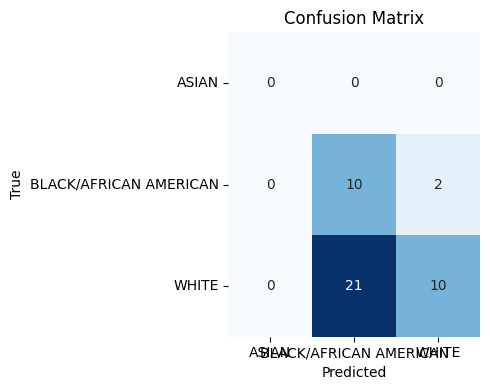

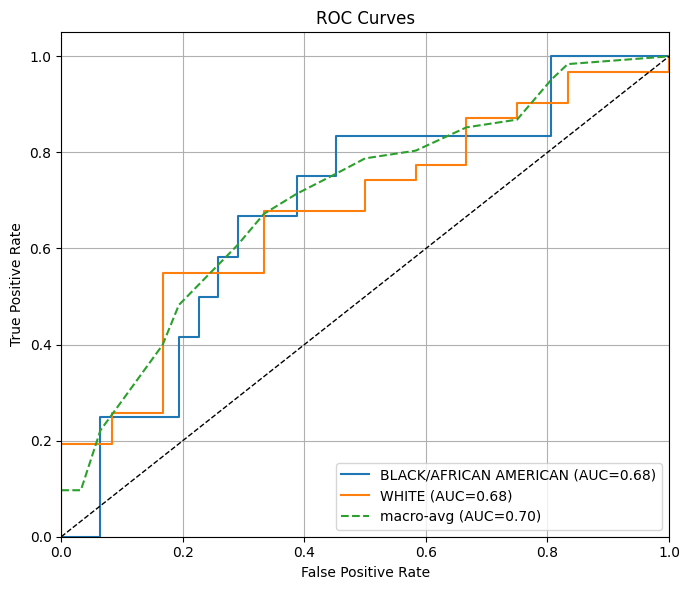

In [151]:
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    precision_recall_fscore_support,
    roc_curve,
    auc,
)
import matplotlib.pyplot as plt
import numpy as np

# 1) Collect predictions, labels, and probabilities
model.eval()
all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for imgs, labs in test_loader:
        imgs = imgs.to(device)
        out  = model(imgs)                  # logits
        probs = torch.softmax(out, dim=1)   # [B,C]
        preds = probs.argmax(dim=1)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labs.numpy())
        all_probs.append(probs.cpu().numpy())

all_preds  = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)
all_probs  = np.vstack(all_probs)  # shape (N, C)

# 2) Classification report & per‑class precision/recall/f1/support
print("Classification Report:\n")
print(classification_report(
    all_labels,
    all_preds,
    labels=list(range(len(unique_labels))),
    target_names=unique_labels,
    zero_division=0
))

# 3) Confusion matrix
cm = confusion_matrix(
    all_labels,
    all_preds,
    labels=list(range(len(unique_labels)))
)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=unique_labels,
            yticklabels=unique_labels,
            cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# 4) ROC Curves & AUC
n_classes = len(unique_labels)
fpr, tpr, roc_auc = {}, {}, {}

# per‑class ROC
for i in range(n_classes):
    y_true_i  = (all_labels == i).astype(int)
    y_score_i = all_probs[:, i]
    # need both pos and neg samples
    if 0 < y_true_i.sum() < len(y_true_i):
        fpr[i], tpr[i], _ = roc_curve(y_true_i, y_score_i)
        roc_auc[i] = auc(fpr[i], tpr[i])

# micro‑avg
y_true_bin = np.eye(n_classes)[all_labels]  
fpr["micro"], tpr["micro"], _ = roc_curve(
    y_true_bin.ravel(), all_probs.ravel()
)
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# macro‑avg: interpolate & average all per‑class curves
all_fpr = np.unique(np.concatenate([fpr[i] for i in roc_auc if isinstance(i,int)]))
mean_tpr = np.zeros_like(all_fpr)
for i in roc_auc:
    if isinstance(i, int):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= sum(1 for i in roc_auc if isinstance(i, int))
fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot
plt.figure(figsize=(7,6))
for i in range(n_classes):
    if i in roc_auc:
        plt.plot(fpr[i], tpr[i],
                 label=f"{unique_labels[i]} (AUC={roc_auc[i]:.2f})")
plt.plot(fpr["macro"], tpr["macro"],
         label=f"macro‑avg (AUC={roc_auc['macro']:.2f})", linestyle='--')
plt.plot([0,1], [0,1], 'k--', lw=1)
plt.xlim(0,1); plt.ylim(0,1.05)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()
